In [3]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=5b273d04dfbea37cf9b7ac46c4ed50b40bb353b5a99e60f80455b3bb763171bb
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
os.chdir('drive/My Drive')
ROOT = os.getcwd()
os.chdir(ROOT + '/Colab Notebooks')

import sys
sys.path.append('../src')

from project_utilities.config import DATA_DIR_RAW

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# XGBoost 
import xgboost as xgb
from xgboost import XGBClassifier

# SKLEARN
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.metrics import recall_score, accuracy_score, mean_squared_error
# Model Optimizer
from bayes_opt import BayesianOptimization

# Progress Bar
from tqdm import tqdm, tqdm_notebook

In [16]:
os.chdir(DATA_DIR_RAW)

In [17]:
train_data = np.load('raw/npy/train_data.npy')
val_data = np.load('raw/npy/val_data.npy')
test_data = np.load('raw/npy/test_data.npy')

y_train = train_data[:,-1]
y_train.reshape(y_train.size,1)
print(f'Shape for y_train: {y_train.shape}')

X_train = train_data[:,:-1]
print(f'Shape for X_train: {X_train.shape}')


y_val = val_data[:,-1]
y_val.reshape(y_val.size,1)
print(f'Shape for y_val: {y_val.shape}')

X_val = val_data[:,:-1]
print(f'Shape for X_val: {X_val.shape}')

y_test = test_data[:,1]
y_test.reshape(y_test.size,1)

X_test = test_data[:,:-1]

Shape for y_train: (3963,)
Shape for X_train: (3963, 50176)
Shape for y_val: (986,)
Shape for X_val: (986, 50176)


In [18]:
ipca = IncrementalPCA(n_components=1300)

X_train_reduced = None
first = True
for batch in tqdm_notebook(np.array_split(X_train, X_train.shape[0]/1000)):
    ipca.partial_fit(batch)
    transformed_batch = ipca.transform(batch)
    # First batch is directly assigned to reduced.
    if first == True:
        X_train_reduced = transformed_batch
        first = False
    else:
        X_train_reduced = np.vstack((X_train_reduced, transformed_batch))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [19]:
        
# Shape of the reduced dataset
print(f'The reduced shape is: {X_train_reduced.shape}')

# Percent of varience explained by the subset of features
print(f'The total explained varience is: {ipca.explained_variance_ratio_.sum()}')

The reduced shape is: (3963, 1300)
The total explained varience is: 0.9816346520522028


In [20]:
X_val_reduced = ipca.transform(X_val)
X_val_reduced.shape

(986, 1300)

In [22]:
X_test_reduced = ipca.transform(X_test)
X_test_reduced.shape

(390, 1300)

In [21]:
xgb_model_1 = XGBClassifier()
xgb_model_1.fit(X_train_reduced, y_train, eval_metric=['error'], eval_set=[(X_train_reduced, y_train),(X_val_reduced, y_val)])

[0]	validation_0-error:0.140298	validation_1-error:0.149087
[1]	validation_0-error:0.133989	validation_1-error:0.148073
[2]	validation_0-error:0.132475	validation_1-error:0.154158
[3]	validation_0-error:0.130457	validation_1-error:0.156187
[4]	validation_0-error:0.128186	validation_1-error:0.146045
[5]	validation_0-error:0.123391	validation_1-error:0.144016
[6]	validation_0-error:0.12213	validation_1-error:0.14503
[7]	validation_0-error:0.118345	validation_1-error:0.139959
[8]	validation_0-error:0.118345	validation_1-error:0.139959
[9]	validation_0-error:0.120363	validation_1-error:0.140974
[10]	validation_0-error:0.117083	validation_1-error:0.139959
[11]	validation_0-error:0.115317	validation_1-error:0.135903
[12]	validation_0-error:0.11456	validation_1-error:0.134888
[13]	validation_0-error:0.113298	validation_1-error:0.13286
[14]	validation_0-error:0.112541	validation_1-error:0.130832
[15]	validation_0-error:0.112036	validation_1-error:0.129817
[16]	validation_0-error:0.109765	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
#Predicting for training set
print('Training Set results:')
train_p1 = xgb_model_1.predict(X_train_reduced)

#Printing the classification report
print(classification_report(train_p1, y_train))

#Predicting for validation set
print('Validation Set results:')
val_p1 = xgb_model_1.predict(X_val_reduced)

#Printing the classification report
print(classification_report(val_p1, y_val))


Training Set results:
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      1045
         1.0       0.99      0.98      0.98      2918

    accuracy                           0.97      3963
   macro avg       0.96      0.97      0.96      3963
weighted avg       0.97      0.97      0.97      3963

Validation Set results:
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       247
         1.0       0.95      0.92      0.94       739

    accuracy                           0.91       986
   macro avg       0.87      0.89      0.88       986
weighted avg       0.91      0.91      0.91       986



Text(0.5, 0, 'Number of iterations')

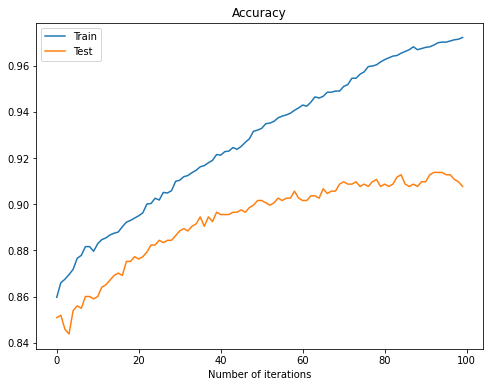

In [ ]:
# Plot and display the performance evaluation
xgb_eval = xgb_model_1.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

In [ ]:
confusion_matrix()

In [ ]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train_reduced, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              #'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse',
              'tree_method': 'gpu_hist'
              }
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


In [ ]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             #'n_estimators':(100,120)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an 
#acquisition function of expected improvement

xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth |
-------------------------------------------------------------
|  1        | -0.3132   |  0.2337   |  0.4631   |  3.226    |
|  2        | -0.3513   |  0.9768   |  0.6651   |  4.612    |
|  3        | -0.2939   |  0.9707   |  0.2176   |  9.168    |
|  4        | -0.3356   |  0.4661   |  0.5942   |  5.737    |
|  5        | -0.4058   |  0.5972   |  0.9249   |  8.466    |
|  6        | -0.3459   |  0.8858   |  0.6429   |  4.486    |
|  7        | -0.391    |  0.09217  |  0.8426   |  6.628    |
|  8        | -0.3212   |  0.2531   |  0.4769   |  6.962    |
|  9        | -0.5      |  0.2349   |  0.0      |  4.669    |
|  10       | -0.4418   |  0.892    |  1.0      |  3.0      |
|  11       | -0.5      |  1.0      |  0.0      |  7.597    |
|  12       | -0.5      |  0.0      |  0.0      |  10.0     |
|  13       | -0.4294   |  1.0      |  1.0      |  10.0     |


In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
#params['n_estimators']= int(params['n_estimators'])

{'gamma': 0.9707481405555448, 'learning_rate': 0.2176132512799489, 'max_depth': 9.167824264171264}


In [ ]:
#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
xgb_model_2 = XGBClassifier(**params).fit(X_train_reduced, y_train, eval_metric=['error'], eval_set=[(X_train_reduced, y_train),(X_val_reduced, y_val)])

#predicting for training set
train_p2 = xgb_model_2.predict(X_train_reduced)

#Looking at the classification report
print(classification_report(train_p2, y_train))

[0]	validation_0-error:0.035327	validation_1-error:0.144016
[1]	validation_0-error:0.024981	validation_1-error:0.138945
[2]	validation_0-error:0.017663	validation_1-error:0.135903
[3]	validation_0-error:0.015645	validation_1-error:0.121704
[4]	validation_0-error:0.011607	validation_1-error:0.123732
[5]	validation_0-error:0.008832	validation_1-error:0.12069
[6]	validation_0-error:0.006561	validation_1-error:0.117647
[7]	validation_0-error:0.004542	validation_1-error:0.11359
[8]	validation_0-error:0.002523	validation_1-error:0.108519
[9]	validation_0-error:0.001514	validation_1-error:0.108519
[10]	validation_0-error:0.001262	validation_1-error:0.108519
[11]	validation_0-error:0.000505	validation_1-error:0.105477
[12]	validation_0-error:0.000252	validation_1-error:0.104462
[13]	validation_0-error:0	validation_1-error:0.106491
[14]	validation_0-error:0	validation_1-error:0.107505
[15]	validation_0-error:0	validation_1-error:0.104462
[16]	validation_0-error:0	validation_1-error:0.102434
[17

In [ ]:
#predicting for validation set
val_p2 = xgb_model_2.predict(X_val_reduced)

#Looking at the classification report
print(classification_report(val_p2, y_val))

#Attained prediction accuracy on the training set
cm = confusion_matrix(train_p2, y_train)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

#Attained prediction accuracy on the validation set
cm = confusion_matrix(val_p2, y_val)
acc_val = cm.diagonal().sum()/cm.sum()
print(acc_val)


              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82       251
         1.0       0.95      0.92      0.94       735

    accuracy                           0.91       986
   macro avg       0.87      0.89      0.88       986
weighted avg       0.91      0.91      0.91       986

1.0
0.9056795131845842


Text(0.5, 0, 'Number of iterations')

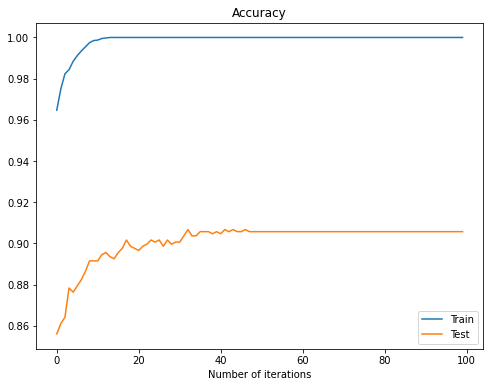

In [ ]:
# Plot and display the performance evaluation
xgb_eval_2 = xgb_model_2.evals_result()
eval_steps = range(len(xgb_eval_2['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval_2['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval_2['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

In [ ]:

preds = xgb_model_2.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_val, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_val, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_val, best_preds)))

In [ ]:
xgb_model_1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}